# HD-NN - Heart Disease Neural Network (PyTorch)

A minimal PyTorch model to predict heart disease using the Kaggle "Heart Disease" dataset.

Dataset
-------
- Kaggle: https://www.kaggle.com/datasets/neurocipher/heartdisease

Author
------
- Kevin Thomas: <ket189@pitt.edu>

License
-------
- MIT

## Config

In [17]:
# CONFIG — Change these for different datasets
DATA_FILE = 'Heart_Disease_Prediction.csv'
TARGET_COL = 'Heart Disease'
TARGET_MAP = {'presence': 1, 'absence': 0}  # set to None if target is already 0/1
MODEL_FILE = 'model.pt'
HIDDEN_DIMS = [64, 32]
DROPOUT = 0.3
SEED, BATCH_SIZE, NUM_EPOCHS = 42, 64, 50

## Install, Import, Device & Seed

In [18]:
# Install required packages
%pip install joblib numpy pandas matplotlib seaborn scikit-learn torch

# Imports, device, and seeds
import os
import random, joblib
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available() else 'cpu')
print('DEVICE:', device)

# Set seed for reproducibility
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
print('SEED:', SEED)

Note: you may need to restart the kernel to use updated packages.
DEVICE: cpu
SEED: 42



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Load Data

In [19]:
# Load data
df = pd.read_csv(DATA_FILE)
print(f'Target: {TARGET_COL}\n{df[TARGET_COL].value_counts()}')

Target: Heart Disease
Heart Disease
Absence     150
Presence    120
Name: count, dtype: int64


## Data Cleaning

In [20]:
# Missing values
print('Missing:\n', df.isnull().sum()[df.isnull().sum() > 0])

Missing:
 Series([], dtype: int64)


## Exploratory Data Analysis

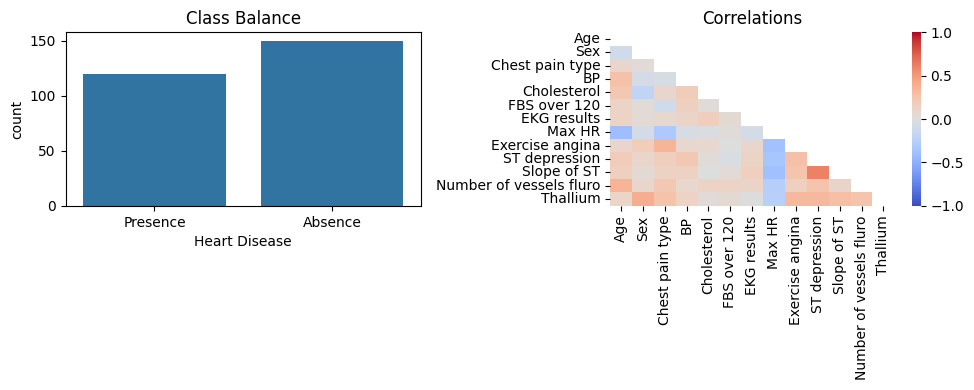

In [21]:
# Class balance
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.countplot(x=TARGET_COL, data=df, ax=axes[0]); axes[0].set_title('Class Balance')

# Correlations
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols].corr()
sns.heatmap(corr, mask=np.triu(np.ones_like(corr, dtype=bool)), cmap='coolwarm', ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title('Correlations')
plt.tight_layout(); plt.show()

## Preprocess

In [22]:
def preprocess(df_in, target_col, target_map=None, scaler=None, fit_scaler=False):
    """
    Preprocess a DataFrame for binary classification modeling.

    This function performs the following preprocessing steps:
    1. Encodes the target column using the provided mapping (if any).
    2. Fills missing numeric values with the column median.
    3. One-hot encodes categorical columns (non-numeric).
    4. Scales numeric features using StandardScaler.

    Parameters
    ----------
    df_in : pandas.DataFrame
        The input DataFrame containing features and target column.
    target_col : str
        The name of the target column to predict.
    target_map : dict, optional
        A dictionary mapping target values to numeric labels (e.g., {'presence': 1, 'absence': 0}).
        If None, the target column is assumed to already contain numeric values.
    scaler : sklearn.preprocessing.StandardScaler, optional
        A pre-fitted StandardScaler to use for transforming features.
        Required if fit_scaler is False and scaling is desired.
    fit_scaler : bool, default=False
        If True, fits a new StandardScaler on the data.
        If False, uses the provided scaler for transformation.

    Returns
    -------
    X : pandas.DataFrame
        The preprocessed feature matrix with scaled numeric columns and one-hot encoded categoricals.
    y : numpy.ndarray
        The encoded target values as a 1D array.
    scaler : sklearn.preprocessing.StandardScaler or None
        The fitted scaler (if fit_scaler=True) or the input scaler.
    """
    df = df_in.copy()
    y = df[target_col].astype(str).str.lower().map(target_map).values if target_map else df[target_col].values
    X = df.drop(columns=[target_col])
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    X[num_cols] = X[num_cols].fillna(X[num_cols].median())
    X = pd.get_dummies(X, columns=[c for c in X.columns if c not in num_cols], drop_first=True)
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    if fit_scaler:
        scaler = StandardScaler()
        X[num_cols] = scaler.fit_transform(X[num_cols])
    elif scaler:
        X[num_cols] = scaler.transform(X[num_cols])
    return X, y, scaler


# Preprocess and save artifacts
X_all, y_all, scaler = preprocess(df, TARGET_COL, TARGET_MAP, fit_scaler=True)
FEATURE_COLS = X_all.columns.tolist()
joblib.dump(scaler, 'scaler.joblib'); joblib.dump(FEATURE_COLS, 'feature_cols.joblib')
print(f'Features: {len(FEATURE_COLS)}')

Features: 13


## Train/Val Split

In [23]:
# Train/val split and DataLoaders
X, y = X_all.values.astype(np.float32), y_all.astype(np.float32)
print(f'Target distribution: {np.sum(y==0)} zeros, {np.sum(y==1)} ones')  # debug
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val)), batch_size=BATCH_SIZE)
print(f'Train: {len(train_loader)} batches, Val: {len(val_loader)} batches')

Target distribution: 150 zeros, 120 ones
Train: 4 batches, Val: 1 batches


## Initialize Model & Optimizer

In [24]:
# If model file exists, remove it
if os.path.exists(MODEL_FILE): os.remove(MODEL_FILE)  # clear old weights


class NeuralNetwork(nn.Module):
    """
    A fully connected neural network for binary classification.

    This model consists of a sequence of fully connected layers with ReLU activations
    and dropout regularization, followed by a final linear layer that outputs a single
    logit value for binary classification.

    Architecture
    ------------
    For each hidden dimension in hidden_dims:
        Linear -> ReLU -> Dropout
    Final layer:
        Linear -> 1 output (logit)

    Attributes
    ----------
    net : torch.nn.Sequential
        The sequential container holding all layers of the network.

    Examples
    --------
    >>> model = NeuralNetwork(input_dim=13, hidden_dims=[64, 32], dropout=0.3)
    >>> x = torch.randn(32, 13)  # batch of 32 samples, 13 features
    >>> logits = model(x)  # shape: (32,)
    """

    def __init__(self, input_dim, hidden_dims=HIDDEN_DIMS, dropout=DROPOUT):
        """
        Initialize the NeuralNetwork.

        Parameters
        ----------
        input_dim : int
            The number of input features.
        hidden_dims : list of int, default=HIDDEN_DIMS
            A list specifying the number of units in each hidden layer.
            For example, [64, 32] creates two hidden layers with 64 and 32 units.
        dropout : float, default=DROPOUT
            The dropout probability applied after each hidden layer.
            Must be between 0 and 1.
        """
        super().__init__()
        layers = []
        for h in hidden_dims:
            layers += [nn.Linear(input_dim, h), nn.ReLU(), nn.Dropout(dropout)]
            input_dim = h
        layers.append(nn.Linear(input_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        """
        Perform a forward pass through the network.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of shape (batch_size, input_dim).

        Returns
        -------
        torch.Tensor
            Output logits of shape (batch_size,). These are raw scores before
            sigmoid activation. Use torch.sigmoid() to convert to probabilities.
        """
        return self.net(x).squeeze(1)


# Initialize model and optimizer
model = NeuralNetwork(X_train.shape[1]).to(device)
criterion, optimizer = nn.BCEWithLogitsLoss(), torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


## Train Model

In [25]:
# Training loop with early stopping
best_loss, patience, patience_ctr = np.inf, 5, 0
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    train_loss = np.mean([
        (optimizer.zero_grad(), loss := criterion(model(xb.to(device)), yb.to(device)), loss.backward(), optimizer.step(), loss.item())[-1]
        for xb, yb in train_loader
    ])
    model.eval()
    with torch.no_grad():
        val_loss = np.mean([criterion(model(xb.to(device)), yb.to(device)).item() for xb, yb in val_loader])
    if val_loss < best_loss:
        best_loss, patience_ctr = val_loss, 0
        torch.save(model.state_dict(), MODEL_FILE)
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print(f'Early stop @ epoch {epoch}'); break
    if epoch % 5 == 0 or epoch == 1:
        print(f'Epoch {epoch}: train={train_loss:.4f} val={val_loss:.4f}')

Epoch 1: train=0.6846 val=0.6748
Epoch 5: train=0.6173 val=0.6165
Epoch 10: train=0.5459 val=0.5222
Epoch 15: train=0.4401 val=0.4362
Epoch 20: train=0.3494 val=0.4185
Early stop @ epoch 24


## Load Model

In [26]:
# Load best model weights
model.load_state_dict(torch.load(MODEL_FILE, map_location=device))
print(f'Training complete. Best val_loss: {best_loss:.4f}')

Training complete. Best val_loss: 0.4178


## Inference

In [27]:
def predict_proba(model, scaler, X, feature_cols, device=device):
    """
    Perform inference on new data using a trained model.

    This function preprocesses the input data by:
    1. Converting to DataFrame format if necessary.
    2. Reindexing to match expected feature columns (filling missing with 0).
    3. Filling any NaN values with the column median.
    4. Scaling features using the provided scaler.
    5. Running inference through the model to get probabilities and predictions.

    Parameters
    ----------
    model : NeuralNetwork
        The trained PyTorch model in evaluation mode.
    scaler : sklearn.preprocessing.StandardScaler
        The fitted scaler used during training to transform features.
    X : pandas.DataFrame or numpy.ndarray
        The input features to predict on. If ndarray, must have columns
        matching the order of feature_cols.
    feature_cols : list of str
        The list of feature column names expected by the model,
        in the correct order.
    device : torch.device, default=device
        The device (CPU/GPU) to run inference on.

    Returns
    -------
    probs : numpy.ndarray
        Predicted probabilities of the positive class, shape (n_samples,).
        Values are between 0 and 1.
    preds : numpy.ndarray
        Binary predictions (0 or 1), shape (n_samples,).
        Threshold is 0.5: preds = 1 if probs >= 0.5 else 0.

    Examples
    --------
    >>> probs, preds = predict_proba(model, scaler, X_test, FEATURE_COLS)
    >>> print(f'Probability: {probs[0]:.3f}, Prediction: {preds[0]}')
    """
    x = pd.DataFrame(X, columns=feature_cols) if not isinstance(X, pd.DataFrame) else X.copy()
    x = x.reindex(columns=feature_cols, fill_value=0)
    x = x.fillna(x.median())
    x[feature_cols] = scaler.transform(x[feature_cols])
    with torch.no_grad():
        probs = torch.sigmoid(model(torch.from_numpy(x.values.astype(np.float32)).to(device))).cpu().numpy()
    return probs, (probs >= 0.5).astype(int)


# Test with already-scaled X_val
model.eval()
with torch.no_grad():
    probs = torch.sigmoid(model(torch.from_numpy(X_val).to(device))).cpu().numpy()
preds = (probs >= 0.5).astype(int)
print(f'Val targets: {int(y_val.sum())}/{len(y_val)} positive ({100*y_val.mean():.1f}%)')
print(f'Predicted:   {preds.sum()}/{len(preds)} positive\n')
print('Sample predictions (first 10):')
for i in range(10):
    actual = 'Presence' if y_val[i] == 1 else 'Absence'
    predicted = 'Presence' if preds[i] == 1 else 'Absence'
    match = '✓' if y_val[i] == preds[i] else '✗'
    print(f'  {i+1}. prob={probs[i]:.3f} → {predicted:8s} (actual: {actual:8s}) {match}')

Val targets: 24/54 positive (44.4%)
Predicted:   27/54 positive

Sample predictions (first 10):
  1. prob=0.180 → Absence  (actual: Absence ) ✓
  2. prob=0.102 → Absence  (actual: Absence ) ✓
  3. prob=0.093 → Absence  (actual: Absence ) ✓
  4. prob=0.856 → Presence (actual: Presence) ✓
  5. prob=0.301 → Absence  (actual: Absence ) ✓
  6. prob=0.131 → Absence  (actual: Absence ) ✓
  7. prob=0.065 → Absence  (actual: Absence ) ✓
  8. prob=0.919 → Presence (actual: Presence) ✓
  9. prob=0.568 → Presence (actual: Presence) ✓
  10. prob=0.673 → Presence (actual: Presence) ✓
